In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from mpl_toolkits.mplot3d import Axes3D

In [28]:
PATH2ROOT = "../../../"
sbj_num = 11
subjects_fol = "subjects/"
sampling_test_fol = "sampling/"

In [122]:
FPS = 15
T = 1/FPS
T_DISCARD = 0.3
X_MERGE = 0.1  # pxr  --> pixel ratio (pixel/screen_width)
Y_MERGE = 0.1  # pxr
VX_THR = 2.5  # pxr/sec
VY_THR = 2.5  # pxr/sec
V_SCALE_SHOW = 10

In [70]:
sampling_test_dir = PATH2ROOT + subjects_fol + f"{sbj_num}/" + sampling_test_fol

with open(sampling_test_dir + "t.pickle", 'rb') as f:
    t = pickle.load(f)
with open(sampling_test_dir + "y-hat-boi.pickle", 'rb') as f:
    boi = pickle.load(f)
with open(sampling_test_dir + "y-hat-et.pickle", 'rb') as f:
    et = pickle.load(f)
    
n_smp = et.shape[0]

In [71]:
vet = et.copy()
vet[1:, 0] = (et[1:, 0] - et[:-1, 0]) / (t[1:] - t[:-1])
vet[1:, 1] = (et[1:, 1] - et[:-1, 1]) / (t[1:] - t[:-1])
vet[0] = vet[1]

Text(0.5, 1.0, 'DISPLAYING SCREEN-RAW DATA')

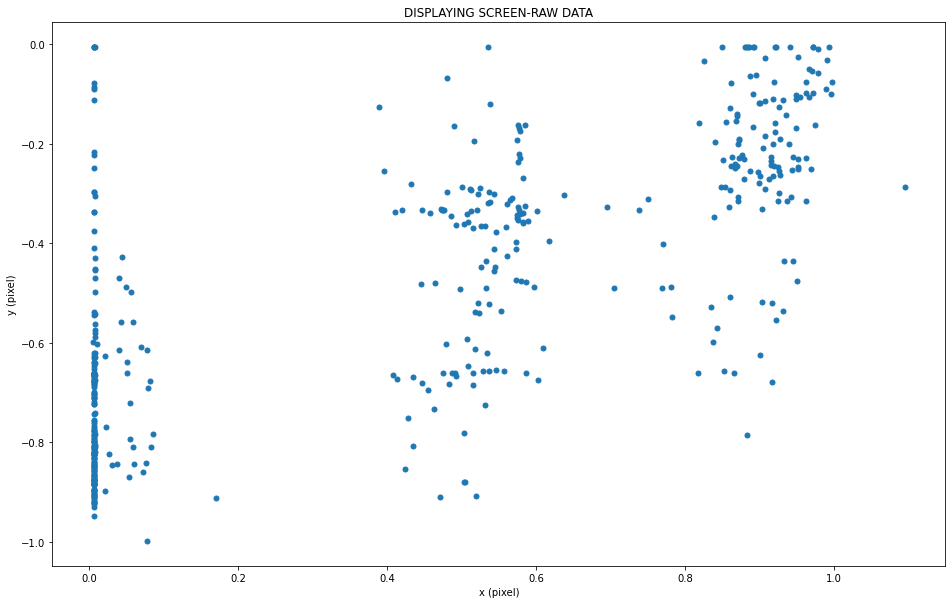

In [76]:
plt.figure(figsize=(16, 10))
plt.plot(np.array(et[:, 0]), -np.array(et[:, 1]), 'o', markersize=5)
plt.xlabel("x (pixel)")
plt.ylabel("y (pixel)")
plt.title("DISPLAYING SCREEN-RAW DATA")

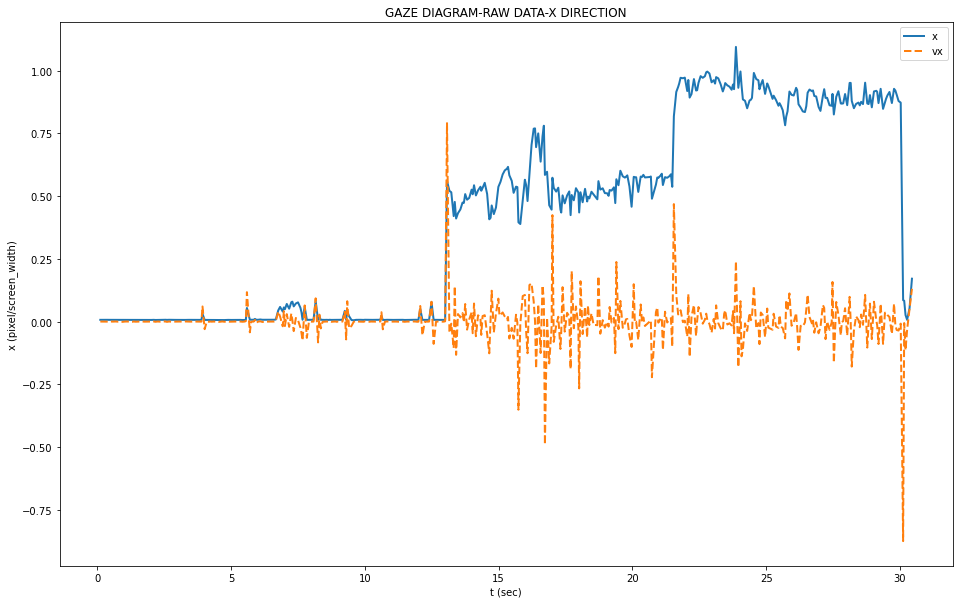

In [123]:
plt.figure(figsize=(16, 10))
plt.plot(t, et[:, 0], linewidth=2, label="x")
plt.plot(t, vet[:, 0]/V_SCALE_SHOW, linestyle='--', linewidth=2, label="vx")
plt.title("GAZE DIAGRAM-RAW DATA-X DIRECTION")
plt.xlabel("t (sec)")
plt.ylabel("x (pixel/screen_width)")
plt.legend(loc="upper right")

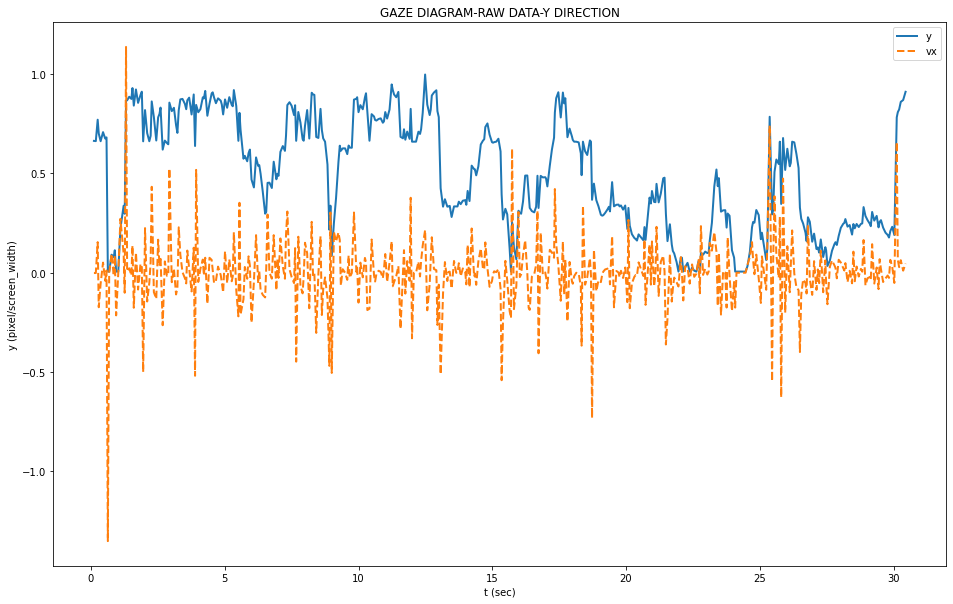

In [124]:
plt.figure(figsize=(16, 10))
plt.plot(t, et[:, 1], linewidth=2, label="y")
plt.plot(t, vet[:, 1]/V_SCALE_SHOW, linestyle='--', linewidth=2, label="vx")
plt.title("GAZE DIAGRAM-RAW DATA-Y DIRECTION")
plt.xlabel("t (sec)")
plt.ylabel("y (pixel/screen_width)")
plt.legend(loc="upper right")

In [80]:
et_in = et.copy()
# not_in = (boi != 2)
# not_in[0] = False
# not_in[-1] = False
# i = 0
# while i<=n_smp-2:
#     j = 0
#     if not_in[i+1]:
#         while not_in[i+j+1]:
#             j += 1
#             if i+j >=n_smp-2:
#                 break
#         det = (et_in[i+j+1]-et_in[i])/(j+1)
#         for (ii, k) in enumerate(range(i+1, i+j+1)):
#             et_in[k] = et_in[i] + (ii+1) * det
#     i += j+1

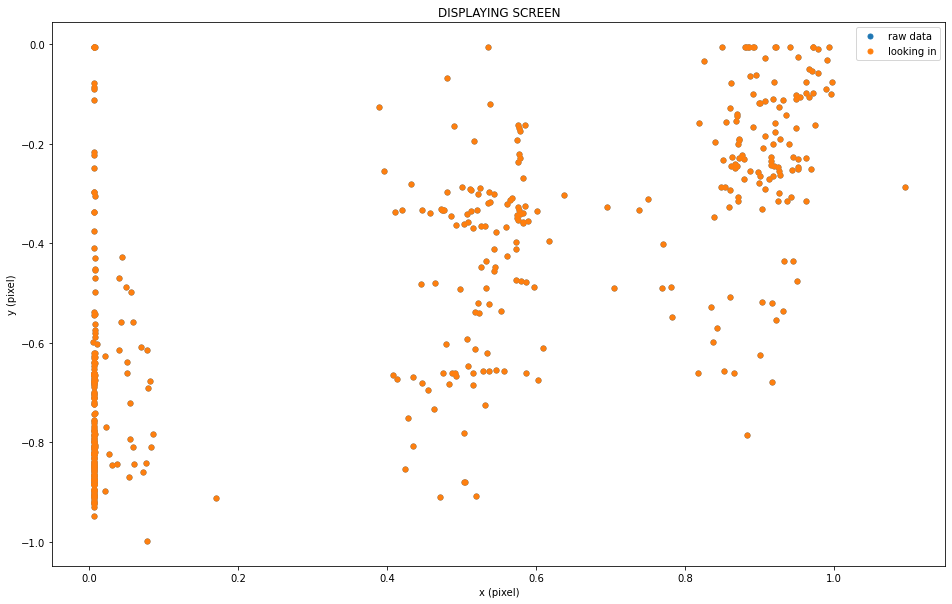

In [81]:
plt.figure(figsize=(16, 10))
plt.plot(np.array(et[:, 0]), -np.array(et[:, 1]), 'o', markersize=5, label="raw data")
plt.plot(np.array(et_in[:, 0]), -np.array(et_in[:, 1]), '*', markersize=5, label="looking_in data")
plt.xlabel("x (pixel)")
plt.ylabel("y (pixel)")
plt.title("DISPLAYING SCREEN")
plt.legend(loc="upper right")

In [86]:
et_med = et_in.copy()
et_med[:,0] = signal.medfilt(et_in[:,0], 5)
et_med[:,1] = signal.medfilt(et_in[:,1], 5)

In [87]:
vet_med = et_med.copy()
vet_med[1:, 0] = (et_med[1:, 0] - et_med[:-1, 0]) / (t[1:] - t[:-1])
vet_med[1:, 1] = (et_med[1:, 1] - et_med[:-1, 1]) / (t[1:] - t[:-1])
vet_med[0] = vet_med[1]

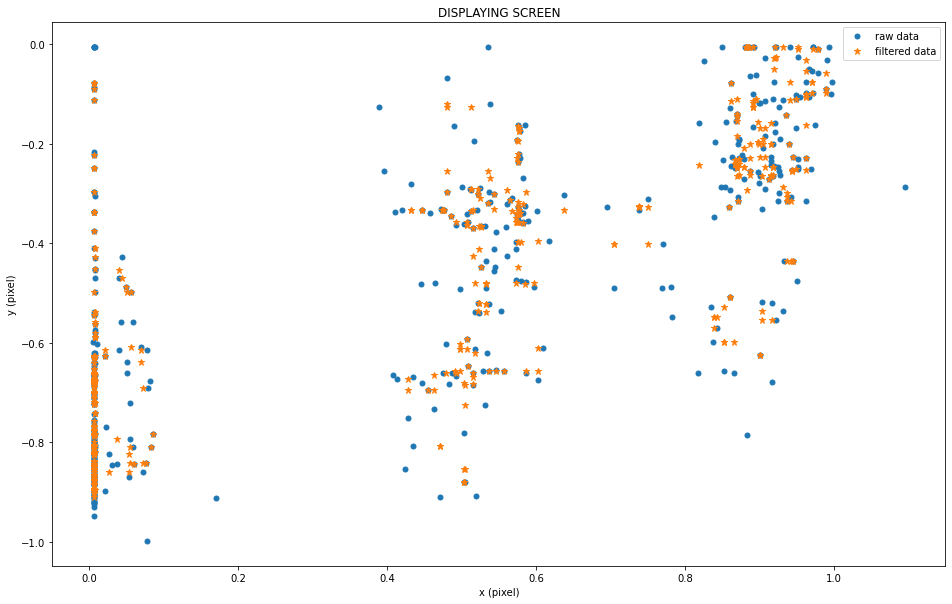

In [88]:
plt.figure(figsize=(16, 10))
plt.plot(np.array(et[:, 0]), -np.array(et[:, 1]), 'o', markersize=5, label="raw data")
plt.plot(np.array(et_med[:, 0]), -np.array(et_med[:, 1]), '*', markersize=7, label="filtered data")
plt.xlabel("x (pixel)")
plt.ylabel("y (pixel)")
plt.title("DISPLAYING SCREEN")
plt.legend(loc="upper right")

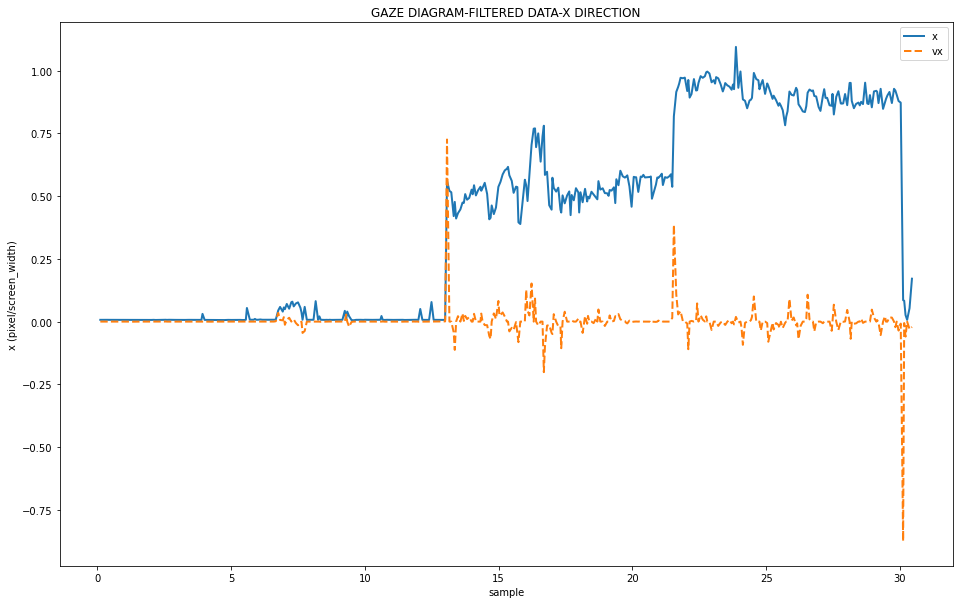

In [125]:
plt.figure(figsize=(16, 10))
plt.plot(t, et[:, 0], linewidth=2, label="x")
plt.plot(t, vet_med[:, 0]/V_SCALE_SHOW, linestyle='--', linewidth=2, label="vx")
plt.title("GAZE DIAGRAM-FILTERED DATA-X DIRECTION")
plt.xlabel("sample")
plt.ylabel("x (pixel/screen_width)")
plt.legend(loc="upper right")

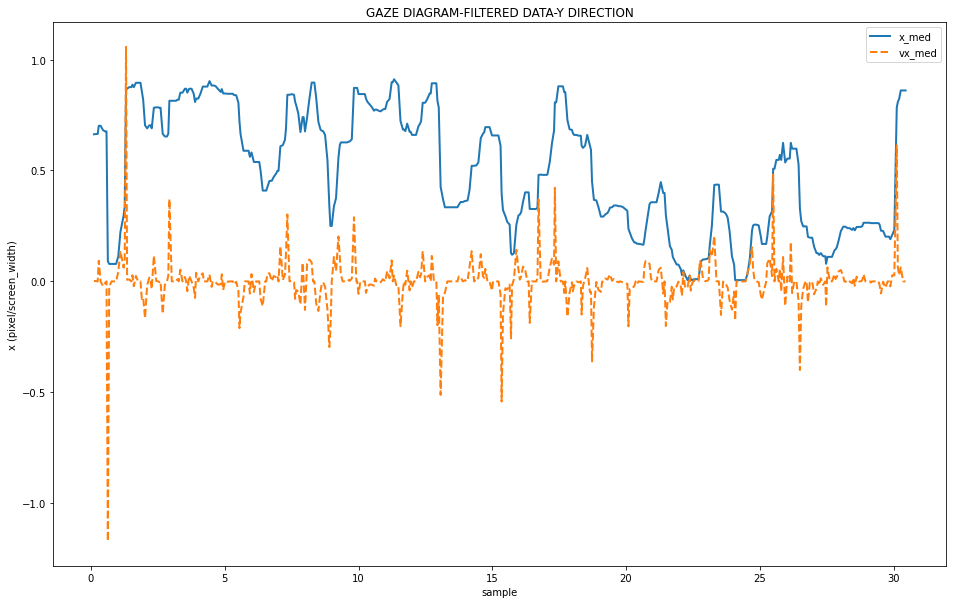

In [126]:
plt.figure(figsize=(16, 10))
plt.plot(t, et_med[:, 1], linewidth=2, label="x_med")
plt.plot(t, vet_med[:, 1]/V_SCALE_SHOW, linestyle='--',linewidth=2, label="vx_med")
plt.title("GAZE DIAGRAM-FILTERED DATA-Y DIRECTION")
plt.xlabel("sample")
plt.ylabel("x (pixel/screen_width)")
plt.legend(loc="upper right")

Text(0.5, 0.92, 'GAZE DIAGRAM IN TIME')

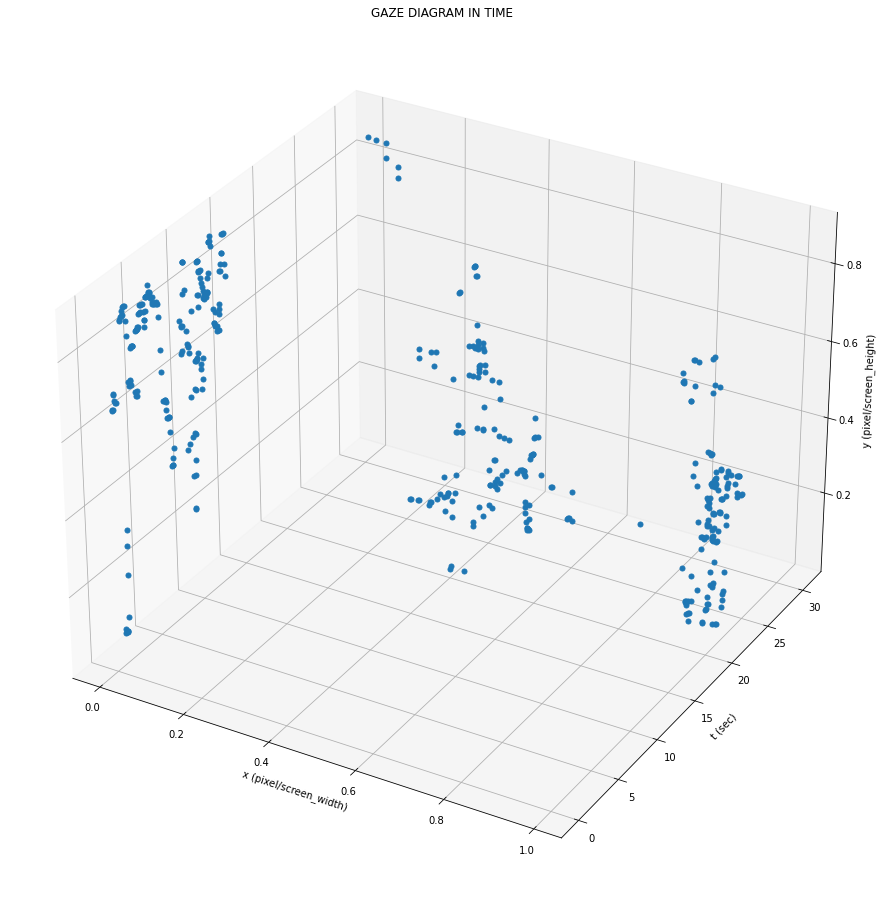

In [92]:
fig = plt.figure(figsize=(16, 16))
ax = fig.add_subplot(111, projection='3d')
ax.plot(et_med[:, 0], t, et_med[:, 1], 'o', markersize=5)
ax.set_xlabel("x (pixel/screen_width)")
ax.set_ylabel("t (sec)")
ax.set_zlabel("y (pixel/screen_height)")
plt.title("GAZE DIAGRAM IN TIME")

In [96]:
sac = ((vet_med[:, 0] > VX_THR) + (vet_med[:, 0] < -VX_THR)) + ((vet_med[:, 1] > VY_THR) + (vet_med[:, 1] < -VY_THR))
sac[0] = True
sac[-1] = True

In [100]:
i = 0
fix = []
while i < n_smp-1:
    if sac[i]:
        j = 0
        while True:
            if sac[i+j+1]:
                break
            else:
                j += 1
        fix.append([i,
                    j,
                    t[i+1],
                    round(t[i+j+1]-t[i+1], 2),
                    round(et_med[i+1:i+j+1, 0].mean(), 4),
                    round(et_med[i+1:i+j+1, 1].mean(), 4)])
        i += j+1
print(fix)

[[0, 7, 0.18, 0.45, 0.0071, 0.6806], [8, 9, 0.68, 0.63, 0.0071, 0.1515], [18, 24, 1.35, 1.58, 0.0067, 0.7827], [43, 65, 3.02, 4.32, 0.0138, 0.7222], [109, 22, 7.42, 1.49, 0.0183, 0.7615], [132, 13, 8.95, 0.88, 0.0092, 0.5224], [146, 48, 9.92, 3.15, 0.0069, 0.7913], [195, 33, 13.16, 2.19, 0.5023, 0.4908], [229, 4, 15.4, 0.3, 0.5545, 0.2849], [234, 15, 15.74, 0.99, 0.625, 0.3076], [250, 8, 16.81, 0.53, 0.5371, 0.5302], [259, 20, 17.39, 1.34, 0.5005, 0.7119], [280, 40, 18.8, 2.75, 0.5628, 0.3055], [321, 57, 21.64, 3.86, 0.9378, 0.146], [379, 14, 25.55, 0.95, 0.8693, 0.5668], [394, 53, 26.55, 3.57, 0.889, 0.2071], [448, 4, 30.16, 0.29, 0.054, 0.8381]]


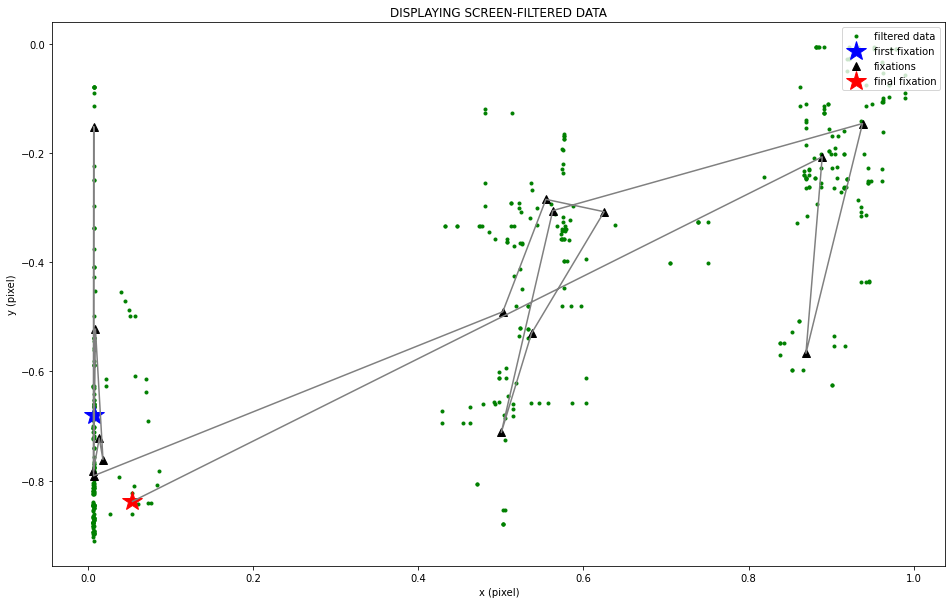

In [117]:
fs_ind = []
fs_x = []
fs_y = []
for f in fix:
    fs_ind.append(f[0])
    fs_x.append(f[4])
    fs_y.append(f[5])

plt.figure(figsize=(16, 10))
plt.plot(np.array(et_med[:, 0]), -np.array(et_med[:, 1]), 'o', markersize=3, label="filtered data", color="green")
plt.plot(np.array(fs_x[0]), -np.array(fs_y[0]), '*', color='blue', markersize=20, label="first fixation")
plt.plot(np.array(fs_x[1:-1]), -np.array(fs_y[1:-1]), '^', label="fixations", color="black", markersize=8)
plt.plot(np.array(fs_x[-1]), -np.array(fs_y[-1]), '*', color='r', markersize=20, label="final fixation")
plt.plot(np.array(fs_x), -np.array(fs_y), color='gray')
plt.xlabel("x (pixel)")
plt.ylabel("y (pixel)")
plt.title("DISPLAYING SCREEN-FILTERED DATA")
plt.legend(loc="upper right")

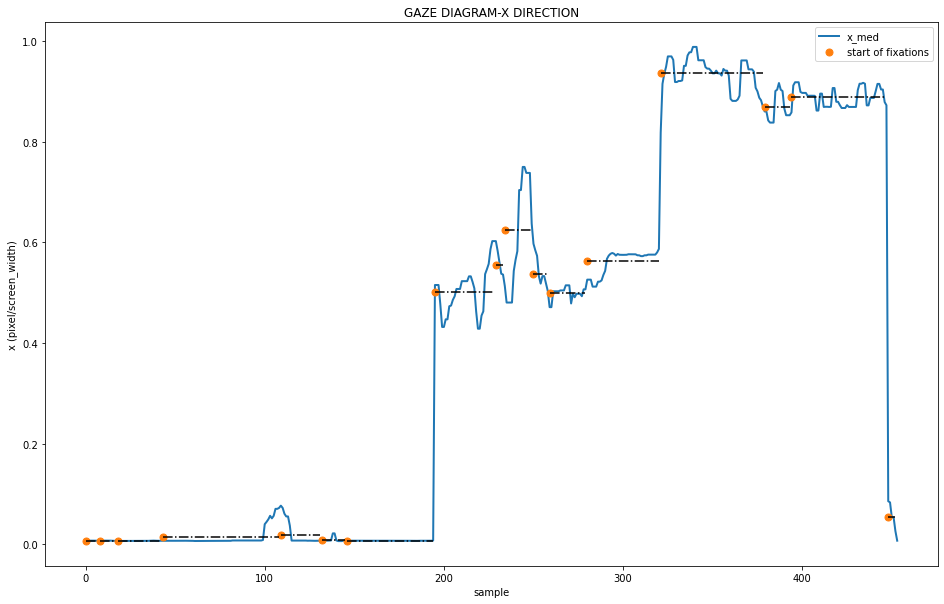

In [128]:
plt.figure(figsize=(16, 10))
plt.plot(et_med[:, 0], linewidth=2, label="x_med")
plt.plot(fs_ind, fs_x, 'o', label="start of fixations", markersize=7)
for f in fix:
    arf_ind = np.arange(f[0], f[0] + f[1] + 1)
    arf_x = np.ones(arf_ind.shape[0]) * f[4]
    plt.plot(arf_ind, arf_x, linestyle='-.',color="black", linewidth=1.5)
plt.title("GAZE DIAGRAM-X DIRECTION")
plt.xlabel("sample")
plt.ylabel("x (pixel/screen_width)")
plt.legend(loc="upper right")

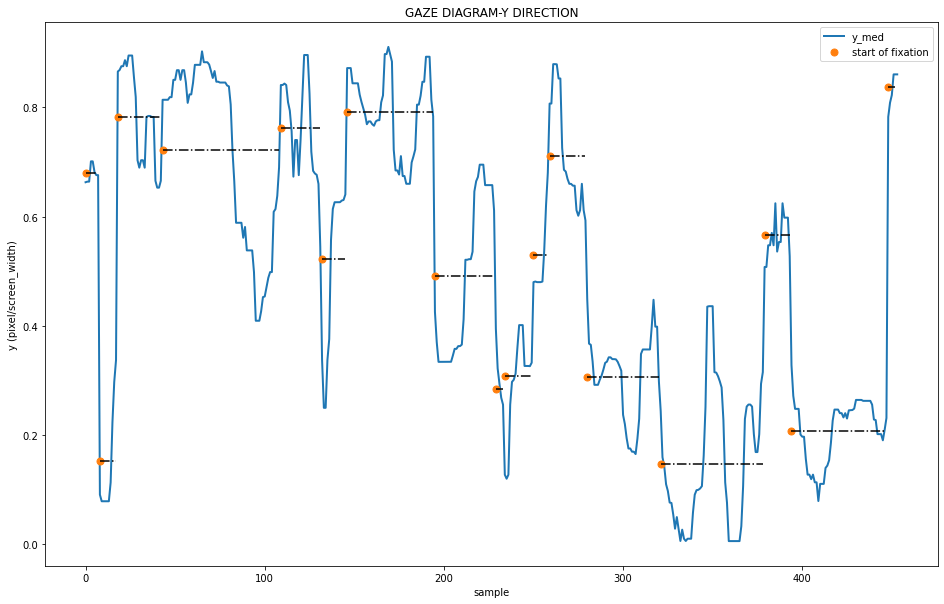

In [129]:
plt.figure(figsize=(16, 10))
plt.plot(et_med[:, 1], linewidth=2, label="y_med")
plt.plot(fs_ind, fs_y, 'o', label="start of fixation", markersize=7)
for f in fix:
    arf_ind = np.arange(f[0], f[0] + f[1] + 1)
    arf_y = np.ones(arf_ind.shape[0]) * f[5]
    plt.plot(arf_ind, arf_y, linestyle='-.',color="black", linewidth=1.5)
plt.title("GAZE DIAGRAM-Y DIRECTION")
plt.xlabel("sample")
plt.ylabel("y (pixel/screen_width)")
plt.legend(loc="upper right")

In [130]:
fix_merge1 = []
f_d = (X_MERGE**2+Y_MERGE**2)**0.5
n_fix = len(fix)
i = 0
while i <= n_fix-2:
    f_new = fix[i]
    j = 1
    while (i+j) <= n_fix:
        fj = fix[i+j]
        fj_d = ((fj[4]-f_new[4])**2+(fj[5]-f_new[5])**2)**0.5
        if fj_d < f_d:
            f_new = [f_new[0],
                     f_new[1] + fj[1],
                     f_new[2],
                     round(f_new[3] + fj[3], 2),
                     round((f_new[4]*f_new[1]+fj[4]*fj[1])/(f_new[1]+fj[1]), 4),
                     round((f_new[5]*f_new[1]+fj[5]*fj[1])/(f_new[1]+fj[1]), 4)]
            not_joined = False
        else:
            fix_merge1.append(f_new)
            not_joined = True
            break
        j += 1
    i += j
    
if not_joined:
    fix_merge1.append(fix[-1])

print(fix_merge1)

[[0, 7, 0.18, 0.45, 0.0071, 0.6806], [8, 9, 0.68, 0.63, 0.0071, 0.1515], [18, 111, 1.35, 7.39, 0.0132, 0.7431], [132, 13, 8.95, 0.88, 0.0092, 0.5224], [146, 48, 9.92, 3.15, 0.0069, 0.7913], [195, 33, 13.16, 2.19, 0.5023, 0.4908], [229, 19, 15.4, 1.29, 0.6102, 0.3028], [250, 8, 16.81, 0.53, 0.5371, 0.5302], [259, 20, 17.39, 1.34, 0.5005, 0.7119], [280, 40, 18.8, 2.75, 0.5628, 0.3055], [321, 57, 21.64, 3.86, 0.9378, 0.146], [379, 14, 25.55, 0.95, 0.8693, 0.5668], [394, 53, 26.55, 3.57, 0.889, 0.2071], [448, 4, 30.16, 0.29, 0.054, 0.8381]]


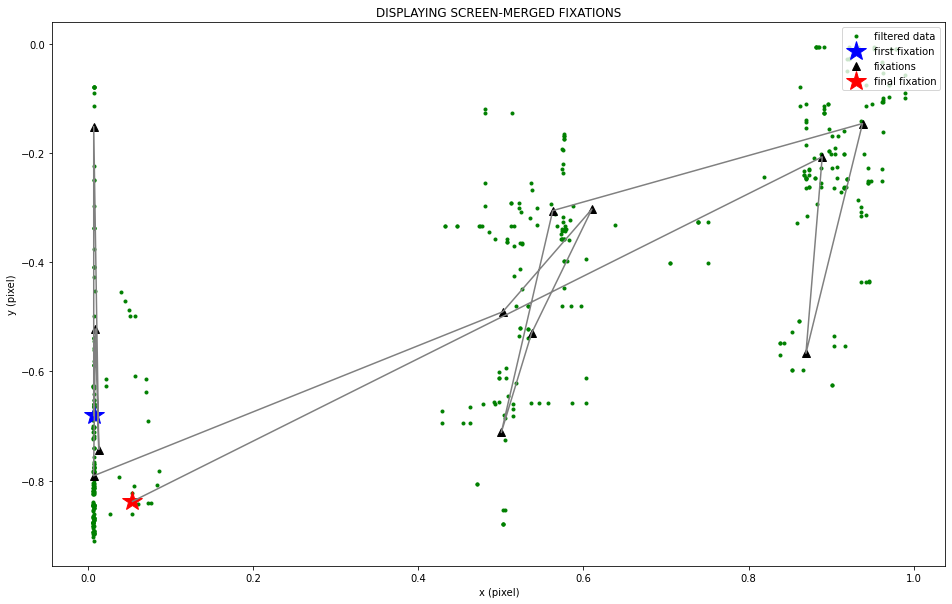

In [134]:
fms1_ind = []
fms1_x = []
fms1_y = []
for f in fix_merge1:
    fms1_ind.append(f[0])
    fms1_x.append(f[4])
    fms1_y.append(f[5])

plt.figure(figsize=(16, 10))
plt.plot(np.array(et_med[:, 0]), -np.array(et_med[:, 1]), 'o', markersize=3, label="filtered data", color="green")
plt.plot(np.array(fms1_x[0]), -np.array(fms1_y[0]), '*', color='blue', markersize=20, label="first fixation")
plt.plot(np.array(fms1_x[1:-1]), -np.array(fms1_y[1:-1]), '^', label="fixations", color="black", markersize=8)
plt.plot(np.array(fms1_x[-1]), -np.array(fms1_y[-1]), '*', color='r', markersize=20, label="final fixation")
plt.plot(np.array(fms1_x), -np.array(fms1_y), color='gray')
plt.xlabel("x (pixel)")
plt.ylabel("y (pixel)")
plt.title("DISPLAYING SCREEN-MERGED FIXATIONS")
plt.legend(loc="upper right")

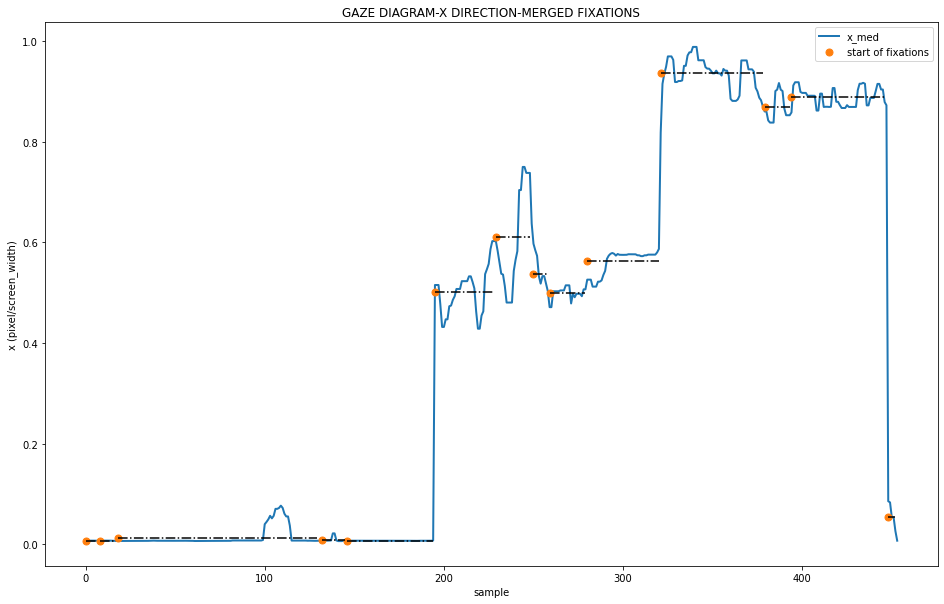

In [135]:
plt.figure(figsize=(16, 10))
plt.plot(et_med[:, 0], linewidth=2, label="x_med")
plt.plot(fms1_ind, fms1_x, 'o', label="start of fixations", markersize=7)
for f in fix_merge1:
    arf_ind = np.arange(f[0], f[0] + f[1] + 1)
    arf_x = np.ones(arf_ind.shape[0]) * f[4]
    plt.plot(arf_ind, arf_x, linestyle='-.',color="black", linewidth=1.5)
plt.title("GAZE DIAGRAM-X DIRECTION-MERGED FIXATIONS")
plt.xlabel("sample")
plt.ylabel("x (pixel/screen_width)")
plt.legend(loc="upper right")

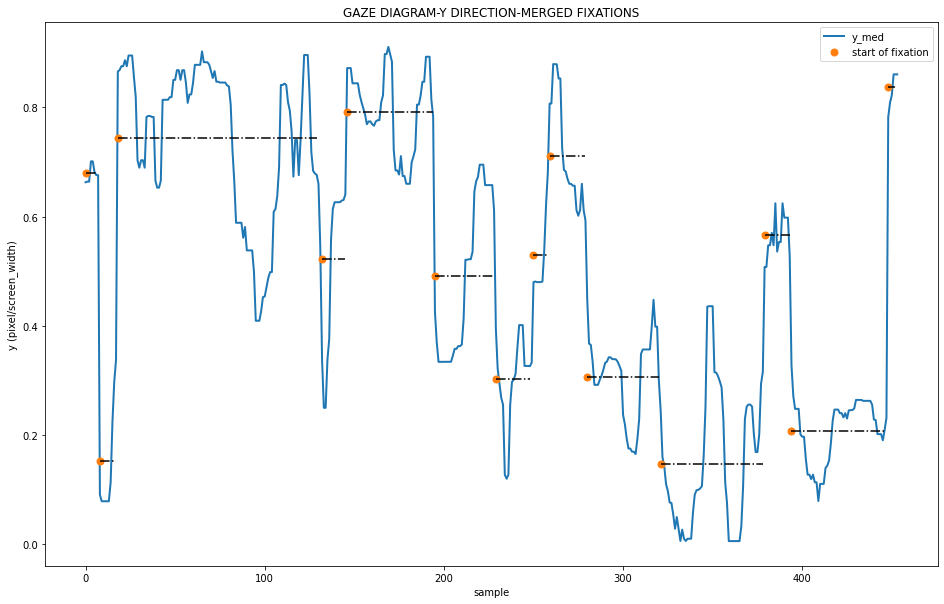

In [137]:
plt.figure(figsize=(16, 10))
plt.plot(et_med[:, 1], linewidth=2, label="y_med")
plt.plot(fms1_ind, fms1_y, 'o', label="start of fixation", markersize=7)
for f in fix_merge1:
    arf_ind = np.arange(f[0], f[0] + f[1] + 1)
    arf_y = np.ones(arf_ind.shape[0]) * f[5]
    plt.plot(arf_ind, arf_y, linestyle='-.',color="black", linewidth=1.5)
plt.title("GAZE DIAGRAM-Y DIRECTION-MERGED FIXATIONS")
plt.xlabel("sample")
plt.ylabel("y (pixel/screen_width)")
plt.legend(loc="upper right")

In [138]:
fix_discard = []
for f in fix_merge1:
    if f[3] >= T_DISCARD:
        fix_discard.append(f)

print(fix_discard)

[[0, 7, 0.18, 0.45, 0.0071, 0.6806], [8, 9, 0.68, 0.63, 0.0071, 0.1515], [18, 111, 1.35, 7.39, 0.0132, 0.7431], [132, 13, 8.95, 0.88, 0.0092, 0.5224], [146, 48, 9.92, 3.15, 0.0069, 0.7913], [195, 33, 13.16, 2.19, 0.5023, 0.4908], [229, 19, 15.4, 1.29, 0.6102, 0.3028], [250, 8, 16.81, 0.53, 0.5371, 0.5302], [259, 20, 17.39, 1.34, 0.5005, 0.7119], [280, 40, 18.8, 2.75, 0.5628, 0.3055], [321, 57, 21.64, 3.86, 0.9378, 0.146], [379, 14, 25.55, 0.95, 0.8693, 0.5668], [394, 53, 26.55, 3.57, 0.889, 0.2071]]


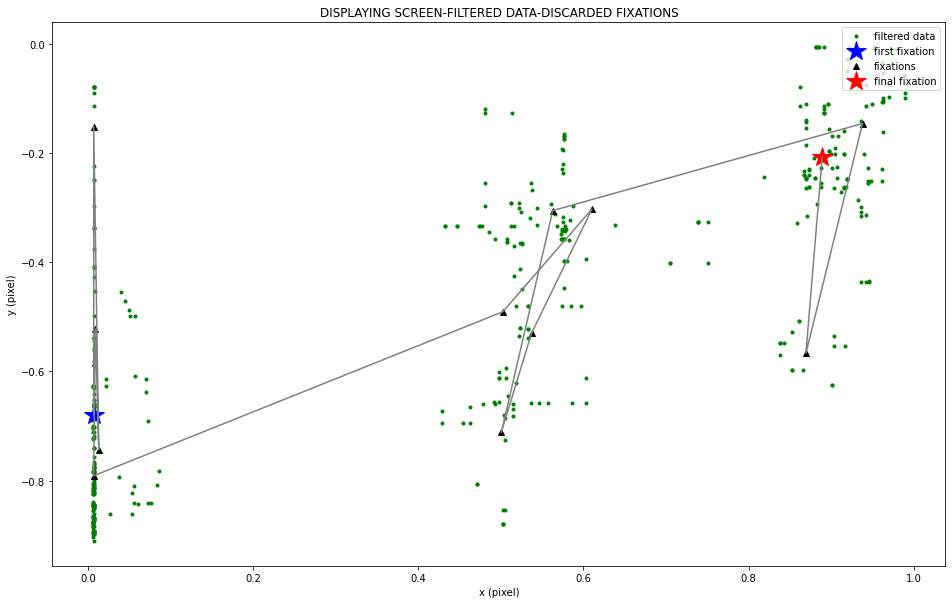

In [140]:
fds_ind = []
fds_x = []
fds_y = []
for f in fix_discard:
    fds_ind.append(f[0])
    fds_x.append(f[4])
    fds_y.append(f[5])
plt.figure(figsize=(16, 10))
plt.plot(np.array(et_med[:, 0]), -np.array(et_med[:, 1]), 'o', markersize=3, label="filtered data", color="green")
plt.plot(np.array(fds_x[0]), -np.array(fds_y[0]), '*', color='blue', markersize=20, label="first fixation")
plt.plot(np.array(fds_x[1:-1]), -np.array(fds_y[1:-1]), '^', label="fixations", color="black")
plt.plot(np.array(fds_x[-1]), -np.array(fds_y[-1]), '*', color='r', markersize=20, label="final fixation")
plt.plot(np.array(fds_x), -np.array(fds_y), color='gray')
plt.xlabel("x (pixel)")
plt.ylabel("y (pixel)")
plt.title("DISPLAYING SCREEN-FILTERED DATA-DISCARDED FIXATIONS")
plt.legend(loc="upper right")

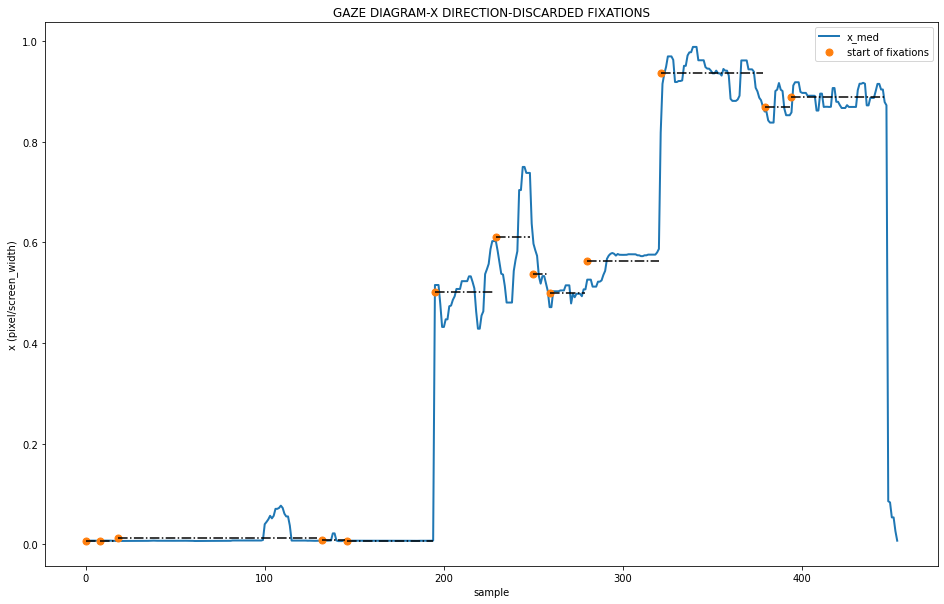

In [141]:
plt.figure(figsize=(16, 10))
plt.plot(et_med[:, 0], linewidth=2, label="x_med")
plt.plot(fds_ind, fds_x, 'o', label="start of fixations", markersize=7)
for f in fix_discard:
    arf_ind = np.arange(f[0], f[0] + f[1] + 1)
    arf_x = np.ones(arf_ind.shape[0]) * f[4]
    plt.plot(arf_ind, arf_x, linestyle='-.',color="black", linewidth=1.5)
plt.title("GAZE DIAGRAM-X DIRECTION-DISCARDED FIXATIONS")
plt.xlabel("sample")
plt.ylabel("x (pixel/screen_width)")
plt.legend(loc="upper right")

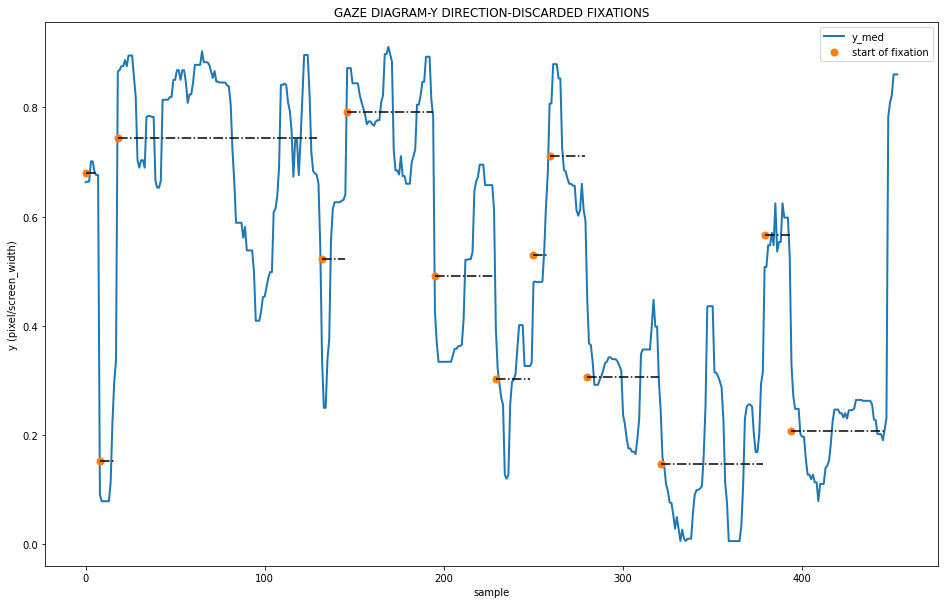

In [142]:
plt.figure(figsize=(16, 10))
plt.plot(et_med[:, 1], linewidth=2, label="y_med")
plt.plot(fds_ind, fds_y, 'o', label="start of fixation", markersize=7)
for f in fix_discard:
    arf_ind = np.arange(f[0], f[0] + f[1] + 1)
    arf_y = np.ones(arf_ind.shape[0]) * f[5]
    plt.plot(arf_ind, arf_y, linestyle='-.',color="black", linewidth=1.5)
plt.title("GAZE DIAGRAM-Y DIRECTION-DISCARDED FIXATIONS")
plt.xlabel("sample")
plt.ylabel("y (pixel/screen_width)")
plt.legend(loc="upper right")

In [143]:
fix_merge2 = []
n_fix2 = len(fix_discard)
i = 0
while i <= n_fix2-2:
    f_new = fix_discard[i]
    j = 1
    while (i+j) <= n_fix2:
        fj = fix_discard[i+j]
        fj_d = ((fj[4]-f_new[4])**2+(fj[5]-f_new[5])**2)**0.5
        if fj_d < f_d:
            f_new = [f_new[0],
                     f_new[1] + fj[1],
                     f_new[2],
                     round(f_new[3] + fj[3], 2),
                     round((f_new[4]*f_new[1]+fj[4]*fj[1])/(f_new[1]+fj[1]), 4),
                     round((f_new[5]*f_new[1]+fj[5]*fj[1])/(f_new[1]+fj[1]), 4)]
            not_joined = False
        else:
            fix_merge2.append(f_new)
            not_joined = True
            break
        j += 1
    i += j
    
if not_joined:
    fix_merge2.append(fix_discard[-1])

print(fix_merge2)

[[0, 7, 0.18, 0.45, 0.0071, 0.6806], [8, 9, 0.68, 0.63, 0.0071, 0.1515], [18, 111, 1.35, 7.39, 0.0132, 0.7431], [132, 13, 8.95, 0.88, 0.0092, 0.5224], [146, 48, 9.92, 3.15, 0.0069, 0.7913], [195, 33, 13.16, 2.19, 0.5023, 0.4908], [229, 19, 15.4, 1.29, 0.6102, 0.3028], [250, 8, 16.81, 0.53, 0.5371, 0.5302], [259, 20, 17.39, 1.34, 0.5005, 0.7119], [280, 40, 18.8, 2.75, 0.5628, 0.3055], [321, 57, 21.64, 3.86, 0.9378, 0.146], [379, 14, 25.55, 0.95, 0.8693, 0.5668], [394, 53, 26.55, 3.57, 0.889, 0.2071]]


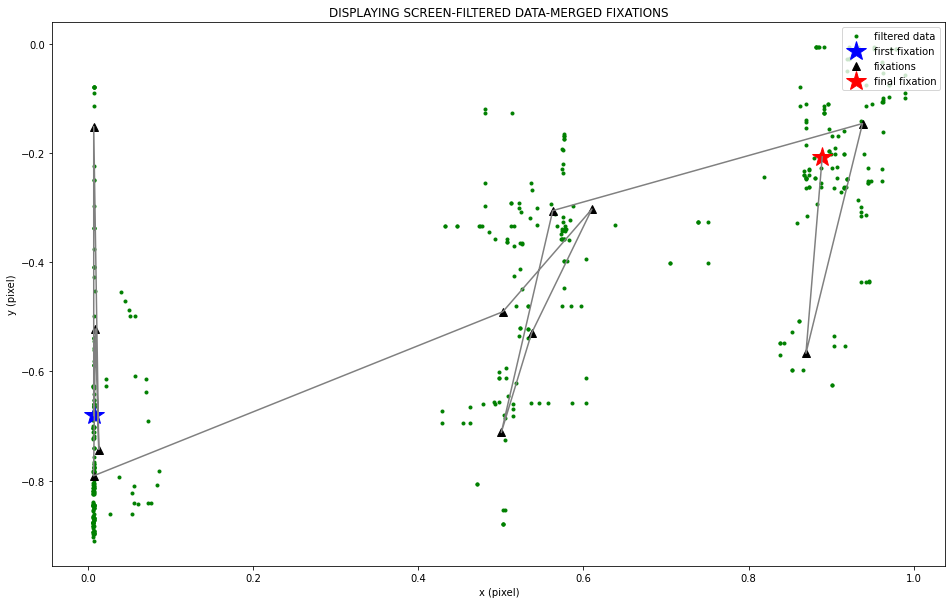

In [145]:
fms2_ind = []
fms2_x = []
fms2_y = []
for f in fix_merge2:
    fms2_ind.append(f[0])
    fms2_x.append(f[4])
    fms2_y.append(f[5])

plt.figure(figsize=(16, 10))
plt.plot(np.array(et_med[:, 0]), -np.array(et_med[:, 1]), 'o', markersize=3, label="filtered data", color="green")
plt.plot(np.array(fms2_x[0]), -np.array(fms2_y[0]), '*', color='blue', markersize=20, label="first fixation")
plt.plot(np.array(fms2_x[1:-1]), -np.array(fms2_y[1:-1]), '^', label="fixations", color="black", markersize=8)
plt.plot(np.array(fms2_x[-1]), -np.array(fms2_y[-1]), '*', color='r', markersize=20, label="final fixation")
plt.plot(np.array(fms2_x), -np.array(fms2_y), color='gray')
plt.xlabel("x (pixel)")
plt.ylabel("y (pixel)")
plt.title("DISPLAYING SCREEN-FILTERED DATA-MERGED FIXATIONS")
plt.legend(loc="upper right")

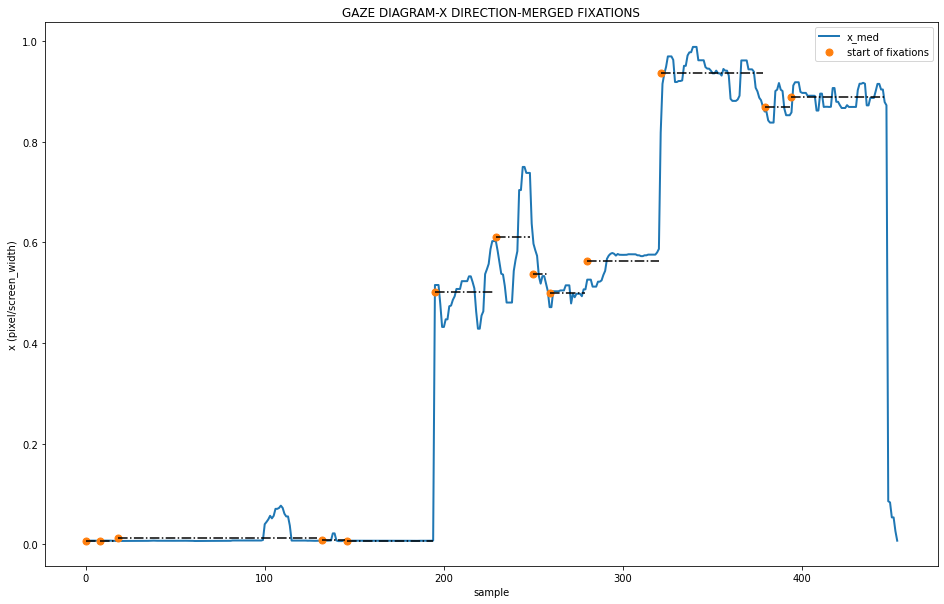

In [146]:
plt.figure(figsize=(16, 10))
plt.plot(et_med[:, 0], linewidth=2, label="x_med")
plt.plot(fms2_ind, fms2_x, 'o', label="start of fixations", markersize=7)
for f in fix_merge2:
    arf_ind = np.arange(f[0], f[0] + f[1] + 1)
    arf_x = np.ones(arf_ind.shape[0]) * f[4]
    plt.plot(arf_ind, arf_x, linestyle='-.',color="black", linewidth=1.5)
plt.title("GAZE DIAGRAM-X DIRECTION-MERGED FIXATIONS")
plt.xlabel("sample")
plt.ylabel("x (pixel/screen_width)")
plt.legend(loc="upper right")

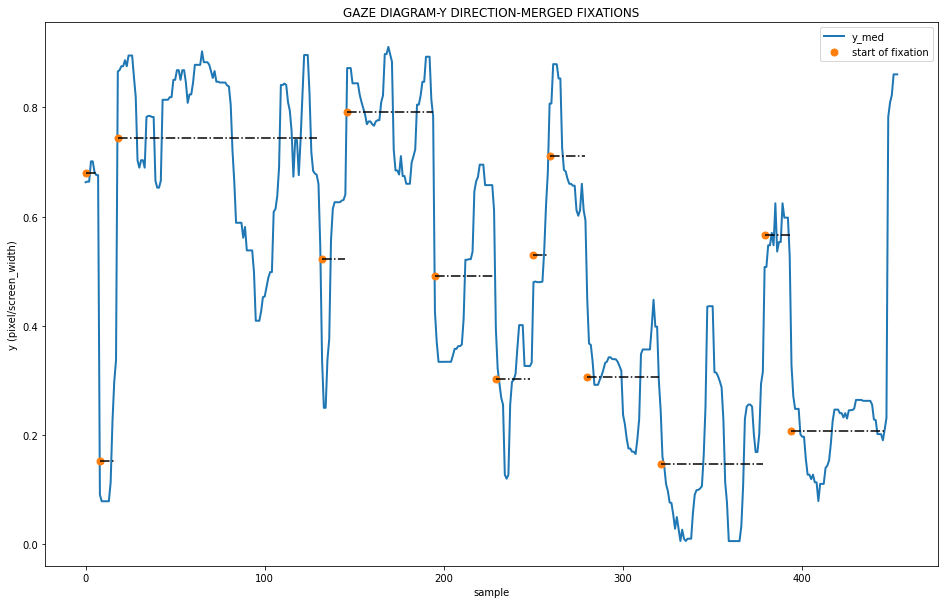

In [155]:
plt.figure(figsize=(16, 10))
plt.plot(et_med[:, 1], linewidth=2, label="y_med")
plt.plot(fms2_ind, fms2_y, 'o', label="start of fixation", markersize=7)
for f in fix_merge2:
    arf_ind = np.arange(f[0], f[0] + f[1] + 1)
    arf_y = np.ones(arf_ind.shape[0]) * f[5]
    plt.plot(arf_ind, arf_y, linestyle='-.',color="black", linewidth=1.5)
plt.title("GAZE DIAGRAM-Y DIRECTION-MERGED FIXATIONS")
plt.xlabel("sample")
plt.ylabel("y (pixel/screen_width)")
plt.legend(loc="upper right")

In [149]:
aoi = [[[0, 0], [0.33, 0.33]], [[0.33, 0], [0.66, 0.33]], [[0.66, 0], [1, 0.33]],
      [[0, 0.33], [0.33, 0.66]], [[0.33, 0.33], [0.66, 0.66]], [[0.66, 0.33], [1, 0.66]],
      [[0, 0.66], [0.33, 1]], [[0.33, 0.66], [0.66, 1]], [[0.66, 0.66], [1, 1]]]

In [150]:
fix_aoi = []
for f in fix_merge2:
    f1 = f.copy()
    xm = f[4]
    ym = f[5]
    for (i, a) in enumerate(aoi):
        if (a[0][0] < xm) and (a[1][0] > xm) and (a[0][1] < ym) and (a[1][1] > ym):
            f1.append(i+1)
    fix_aoi.append(f1)

print(fix_aoi)

[[0, 7, 0.18, 0.45, 0.0071, 0.6806, 7], [8, 9, 0.68, 0.63, 0.0071, 0.1515, 1], [18, 111, 1.35, 7.39, 0.0132, 0.7431, 7], [132, 13, 8.95, 0.88, 0.0092, 0.5224, 4], [146, 48, 9.92, 3.15, 0.0069, 0.7913, 7], [195, 33, 13.16, 2.19, 0.5023, 0.4908, 5], [229, 19, 15.4, 1.29, 0.6102, 0.3028, 2], [250, 8, 16.81, 0.53, 0.5371, 0.5302, 5], [259, 20, 17.39, 1.34, 0.5005, 0.7119, 8], [280, 40, 18.8, 2.75, 0.5628, 0.3055, 2], [321, 57, 21.64, 3.86, 0.9378, 0.146, 3], [379, 14, 25.55, 0.95, 0.8693, 0.5668, 6], [394, 53, 26.55, 3.57, 0.889, 0.2071, 3]]


In [152]:
fs_in_aoi = np.zeros((9, 2))

for f in fix_aoi:
    fs_in_aoi[f[-1]-1, 0] = fs_in_aoi[f[-1]-1, 0] + 1
    fs_in_aoi[f[-1]-1, 1] = fs_in_aoi[f[-1]-1, 1] + f[3]

print(fs_in_aoi)

[[ 1.    0.63]
 [ 2.    4.04]
 [ 2.    7.43]
 [ 1.    0.88]
 [ 2.    2.72]
 [ 1.    0.95]
 [ 3.   10.99]
 [ 1.    1.34]
 [ 0.    0.  ]]


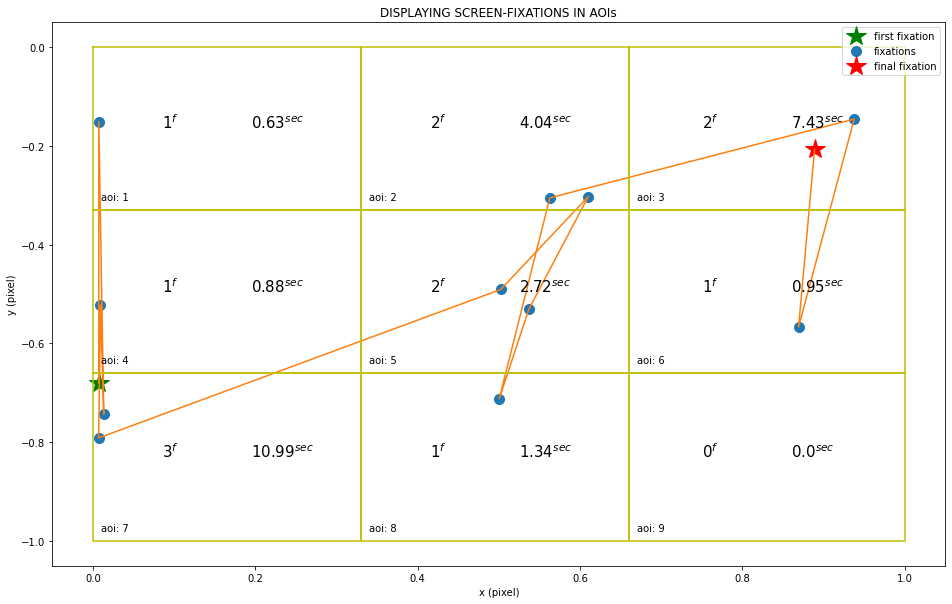

In [154]:
ff_ind = []
ff_x = []
ff_y = []
for f in fix_aoi:
    ff_ind.append(f[0])
    ff_x.append(f[4])
    ff_y.append(f[5])

plt.figure(figsize=(16, 10))
plt.plot(np.array(ff_x[0]), -np.array(ff_y[0]), '*', color='green', markersize=20, label="first fixation")
plt.plot(np.array(ff_x[1:-1]), -np.array(ff_y[1:-1]), 'o', label="fixations", markersize=10)
plt.plot(np.array(ff_x[-1]), -np.array(ff_y[-1]), '*', color='r', markersize=20, label="final fixation")
plt.plot(np.array(ff_x), -np.array(ff_y))
for (i, a) in enumerate(aoi):
    box_x = [a[0][0], a[0][0], a[1][0], a[1][0], a[0][0]]
    box_y = [a[0][1], a[1][1], a[1][1], a[0][1], a[0][1]]
    plt.plot(np.array(box_x), -np.array(box_y), color="y")
    plt.text(box_x[1]+0.01, -box_y[1]+0.02, "aoi: " + f"{i+1}")
    plt.text((box_x[0]+box_x[2])/2-0.08, -(box_y[0]+box_y[2])/2, str(round(fs_in_aoi[i, 0]))+r"$^f$", fontsize=15)
    plt.text((box_x[0]+box_x[2])/2+0.03, -(box_y[0]+box_y[2])/2, str(round(fs_in_aoi[i, 1], 2))+r"$^{sec}$", fontsize=15)
plt.xlabel("x (pixel)")
plt.ylabel("y (pixel)")
plt.title("DISPLAYING SCREEN-FIXATIONS IN AOIs")
plt.legend(loc="upper right")